# AIM

DQN  
簡単な問題でテスト

# REFERENCE

* [https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf)

In [1]:
import copy
import time
import gym
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline
import chainer
import chainer.links as L
import chainer.functions as F
from chainer import Chain, optimizers, Variable, serializers

In [2]:
from pkg_resources import get_distribution
import platform
print("python", platform.python_version())
print("")
libs = ["numpy", "matplotlib", "gym"]
for lib in libs:
    version = get_distribution(lib).version
    print(lib, version)

python 3.5.2

numpy 1.13.1
matplotlib 2.0.2
gym 0.9.2


In [3]:
env = gym.make("FrozenLake-v0")
print("observation_space.n:", env.observation_space.n)
print("action_space.n: ", env.action_space.n)
print("")

obs = env.reset()
print("obs: ", obs)
env.render()
print("")

act = env.action_space.sample()
obs = env.step(act)
print("act: ", act)
print("obs: ", obs)
env.render()
print("")

[2017-09-08 11:02:03,550] Making new env: FrozenLake-v0


observation_space.n: 16
action_space.n:  4

obs:  0

SFFF
FHFH
FFFH
HFFG

act:  0
obs:  (4, 0.0, False, {'prob': 0.3333333333333333})
  (Left)
SFFF
FHFH
FFFH
HFFG



[2017-09-08 12:06:22,810] Making new env: FrozenLake-v0


Train
epoch	EPSILON	reward	total_step	loss	elapsed_time
10	1	0.0	57	0	0.003972053527832031[sec]
20	1	0.0	165	0	0.004951000213623047[sec]
30	1	0.0	246	0	0.0032389163970947266[sec]
40	1	0.0	315	0	0.0027260780334472656[sec]
50	1	0.0	419	0	0.0037391185760498047[sec]
60	1	1.0	483	0	0.0027379989624023438[sec]
70	1	0.0	568	0	0.0030710697174072266[sec]
80	1	0.0	633	0	0.0024809837341308594[sec]
90	1	0.0	706	0	0.0035910606384277344[sec]
100	1	0.0	777	0	0.0025129318237304688[sec]
110	1	0.0	874	0	0.0031728744506835938[sec]
120	1	1.0	950	0	0.002994060516357422[sec]
130	0.7299999999999998	0.0	1055	0.076654676348	0.30752992630004883[sec]
140	0.25999999999999934	0.0	1149	0.134510214528	0.49757909774780273[sec]
150	0.00999999999999918	1.0	1241	0.201021548826	0.5720868110656738[sec]
160	0.00999999999999918	3.0	1537	0.849550169311	1.756993055343628[sec]
170	0.00999999999999918	7.0	1884	1.43902565259	1.9722990989685059[sec]
180	0.00999999999999918	7.0	2180	1.0851819258	1.6136651039123535[sec]
190	0.009999

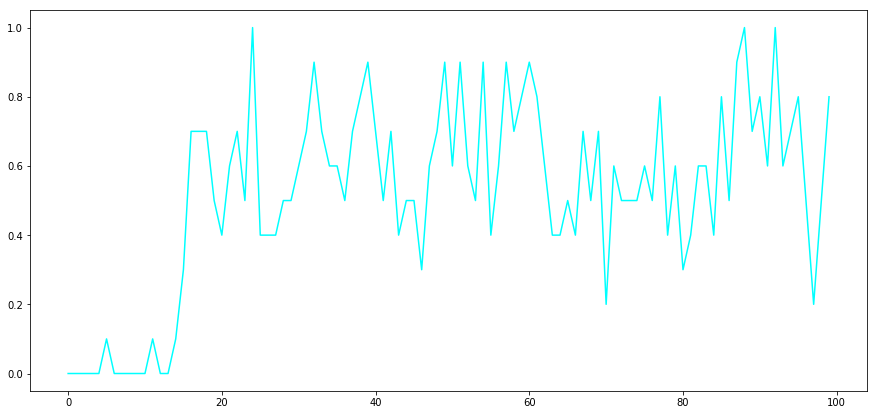

In [10]:
# 環境
env = gym.make("FrozenLake-v0")

# CNNクラス定義
class CNN(Chain):
    def __init__(self):
        super(CNN, self).__init__(
            xc = L.Convolution2D(None, 8, (2, 2)),
            ch = L.Linear(32, 100),
            hy = L.Linear(100, 4)
        )
        
    def __call__(self, x):
        x = Variable(x)
        h = F.max_pooling_2d(F.relu(self.xc(x)), 2)
        h = F.relu(self.ch(h))
        y = F.relu(self.hy(h))
        return y
        
    def reset(self):
        self.zerograds()
        
# 画像変換関数定義
def convert(obs):
    tmp = np.zeros(16)
    tmp[obs] = 1
    obs = np.array(tmp, dtype="float32")
    obs = obs.reshape(4,4)
    return obs

# モデル
Q = CNN() # 近似Q関数
#serializers.load_npz("./******.npz", q) # 重みファイル読み込み
Q_ast = copy.deepcopy(Q)
optimizer = optimizers.Adam()
optimizer.setup(Q)

# 定数
EPOCH_NUM = 1000 # エポック数
MEMORY_SIZE = 1000 # メモリサイズいくつで学習を開始するか
BATCH_SIZE = 100 # バッチサイズ
EPSILON = 1 # ε-greedy法
EPSILON_DECREASE = 0.005 # εの減少値
EPSILON_MIN = 0.01 # εの下限
START_REDUCE_EPSILON = 1000 # εを減少させるステップ数
TRAIN_FREQ = 10 # Q関数の学習間隔
UPDATE_TARGET_Q_FREQ = 20 # Q関数の更新間隔
GAMMA = 0.99

total_step = 0 # 総ステップ（行動）数
memory = [] # メモリ
total_rewards = [] # 累積報酬記録用リスト
total_losses = [] # 累積損失記録用リスト

# 学習開始
print("Train")
print("\t".join(["epoch", "EPSILON", "reward", "total_step", "loss", "elapsed_time"]))
start = time.time()
for epoch in range(EPOCH_NUM):
    pobs = env.reset() # 環境初期化
    pobs = convert(pobs)
    converted_height, converted_width = pobs.shape[0], pobs.shape[1] # 後で利用するので、変換後のサイズを取得
    done = False # ゲーム終了フラグ
    total_reward = 0 # 累積報酬
    total_loss = 0 # 累積損失
    while not done:
        # 行動選択
        pact = env.action_space.sample()
        if np.random.rand() > EPSILON: # ε-greedy法
            pact = Q(pobs.reshape((1, 1, converted_height, converted_width))) # 最適な行動を予測 # batchsize, channel, height, width
            pact = np.argmax(pact.data)
        # 行動
        obs, reward, done, _ = env.step(pact)
        obs = convert(obs)
        # メモリに蓄積
        memory.append((pobs, pact, reward, obs, done)) # 変換済みの行動前状態ベクトル、未変換の行動ラベル、報酬、変換済みの行動後状態ベクトル、ゲーム終了フラグ
        if len(memory) > MEMORY_SIZE: # メモリサイズを超えていれば消していく
            memory.pop(0)
        # 学習
        if len(memory) == MEMORY_SIZE: # メモリサイズ分溜まっていれば学習
            # 経験リプレイ
            if total_step % TRAIN_FREQ == 0:
                np.random.shuffle(memory)
                memory_idx = range(len(memory))
                for i in memory_idx[::BATCH_SIZE]:
                    batch = np.array(memory[i:i+BATCH_SIZE]) # 経験ミニバッチ
                    pobss = np.array(batch[:,0].tolist(), dtype="float32").reshape((BATCH_SIZE, 1, converted_height, converted_width))
                    pacts = np.array(batch[:,1].tolist(), dtype="int32")
                    rewards = np.array(batch[:,2].tolist(), dtype="int32")
                    obss = np.array(batch[:,3].tolist(), dtype="float32").reshape((BATCH_SIZE, 1, converted_height, converted_width))
                    dones = np.array(batch[:,4].tolist(), dtype="bool")
                    # set y
                    q = Q(pobss)
                    maxq = list(map(np.max, Q_ast(obss).data)) # maxQ
                    target = copy.deepcopy(q.data)
                    for j in range(BATCH_SIZE):
                        target[j, pacts[j]] = rewards[j]+GAMMA*maxq[j]*(not dones[j])
                    # Perform a gradient descent step
                    Q.reset()
                    loss = F.mean_squared_error(q, Variable(target))
                    total_loss += loss.data
                    loss.backward()
                    optimizer.update()
            # Q関数の更新
            if total_step % UPDATE_TARGET_Q_FREQ == 0:
                Q_ast = copy.deepcopy(Q)
        # εの減少
        if EPSILON > EPSILON_MIN:
            if total_step > START_REDUCE_EPSILON:
                EPSILON -= EPSILON_DECREASE
        # 次の行動へ
        total_reward += reward
        total_step += 1
        pobs = obs
    total_rewards.append(total_reward) # 累積報酬を記録
    total_losses.append(total_loss) # 累積損失を記録
    #serializers.save_npz("./******.npz", q) # 重みファイル出力
    if (epoch+1) % 10 == 0:
        elapsed_time = time.time()-start
        r = sum(total_rewards[((epoch+1)-10):(epoch+1)])
        l = sum(total_losses[((epoch+1)-10):(epoch+1)])
        print("\t".join(map(str,[epoch+1, EPSILON, r, total_step, l, str(elapsed_time)+"[sec]"]))) # ログ出力
        start = time.time()
        
plt.figure(figsize=(15,7))
resize = (len(total_rewards)//10, 10)
tmp = np.array(total_rewards, dtype="float32").reshape(resize)
tmp = np.average(tmp, axis=1)
plt.plot(tmp, color="cyan")
plt.show()